In [1]:
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, Tensor
import networkx as nx

import extension as ext
from extension import utils
from segmentation.segment_anything.tree_2d_segmentation import TreeStructure
from segmentation.segment_anything.tree_3d_seg import Tree3D

%load_ext autoreload
%autoreload 2
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = torch.device('cuda')

# 一. 生成大量二维树分割结果

- 给定一个mesh $S$
- 在制定范围内生成$K$个视角$\{\pi_i\}_i^{K}$, 每个视角渲染一张图片$I_i$及像素与三角面片间的对应关系$C_i$: $$I_i, C_i = \mathrm{render}(S, \pi_i)$$
- 对每张图片$I_i$进行二维树分割, 得到结果$T^{2d}_i = \{m_j\}_{j=1}^{N_i}$, 其中$N_i$表示分割结果的数量

In [3]:
root = Path('~/wan_code/segmentation/segment_anything/results/').expanduser()
# save_root = root / '12612b82ea88a8977007b330cacd9453'  # tang_table
# save_root = root / 'c44102ae857d5428fa4e91279f4e43e1'  # table and chairs
save_root = root / 'cbec970966b1cfc31013390074d5de0a'  # chairs
seg_2d_files = sorted(list(save_root.glob('*.data')))[:10]
print(f'There are {len(seg_2d_files)} data')
data = [torch.load(filename, map_location=device) for filename in seg_2d_files]
print(utils.show_shape(data[0]))

There are 10 data
{'tree_data': {'masks': IntTensor[4, 1024, 1024], 'iou_preds': F32Tensor[17], 'points': F64Tensor[17, 2], 'stability_score': F32Tensor[17], 'boxes': F32Tensor[17, 4], 'area': LongTensor[17], 'parent': IntTensor[18], 'first': IntTensor[18], 'next': IntTensor[18], 'last': IntTensor[18], 'cnt': 17, 'num_samples': IntTensor[18], 'extra': {}}, 'image': numpy((1024, 1024, 3), float32), 'tri_id': IntTensor[1024, 1024], 'Tw2v': F32Tensor[4, 4]}


In [4]:
all_masks = [data_i['tree_data']['masks'] for data_i in data]  # type: List[List[Tensor]]
all_masks_info = []
all_masks_loc = []
masks_info = {}
masks_index = {}
cnt = 0
for k, masks in enumerate(all_masks):
    all_masks_info.append([])
    all_masks_loc.append({})
    for i in range(1, len(masks)):
        for j in masks[i].unique():
            j = j.item()
            if j <= 0:
                continue
            all_masks_info[k].append((i, j))
            all_masks_loc[k][j] = (i, (masks[i] == j).sum().item())
            masks_info[cnt] = (k, i, j)
            masks_index[(k, i, j)] = cnt
            cnt += 1
print(f"There are {cnt} masks")

There are 148 masks


In [5]:
# print(list(save_root.glob('*')))
mesh = torch.load(list(save_root.glob('*.mesh_cache'))[0])
print(mesh)
num_faces = mesh.f_pos.shape[0]
# num_faces = 72014
print('num faces:', num_faces)

Mesh(vertices=42485, faces=84762, tex, nrm, tng, mat=['bsdf', 'ks', 'name', 'kd', 'ka'])
num faces: 84762


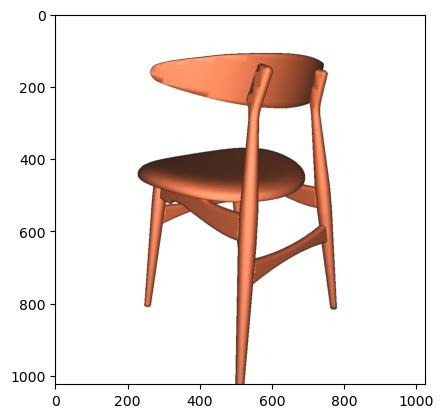

In [6]:
plt.imshow(data[2]['image'].clip(0, 1))

In [7]:
tri_uni = [item['tri_id'].unique(return_counts=True) for item in data]

# 三维树分割
将 $\{m^i_j\}$ 划分为$L$个类$M_l = \{m^l_1, m^l_2, \dots, m^l_{Nm_l}\}$, $M_l$包含的三角面片为:
$$M_l = \{x \mid \frac{\sum{area(x, C_i \cdot m^l_i)}}{\sum{area(x, C_i)}} \ge 0.5\}$$

将$M_1, \dots, M_L$ 组成一棵树$\mathbf{T}=\{T_i\}_{i=1}^{L}$, 对于任意结点$i$, 其父节点$p$满足:

$$\arg\max_{p} \{area(M_p \& M_i) \mid In(M_i, M_p) > In(M_p, M_i)\}$$

$In(M_i, M_p) = \frac{area(M_i \& M_p)}{area(M_i)}$表示相交部分在$M_i$中的比例

In [8]:
def IoU(m1: Tensor, m2: Tensor, tree=None):
    assert m1.dtype == torch.bool and m2.dtype == torch.bool, f"dtype: mask1 {m1.dtype}, mask2: {m2.dtype}"
    if tree is None:
        return (m1 & m2).sum().item() / (m1 | m2).sum().item()
    else:
        return ((m1 & m2)[1:] * tree.area).sum().item() / ((m1 | m2)[1:] * tree.area).sum().item()


In [9]:
eps = 1e-7


class Tree3D_(TreeStructure):
    def __init__(self, mesh: ext.Mesh, verbose=0, device=None):
        self.mesh = mesh
        v3 = mesh.v_pos[mesh.f_pos]  # shape: (F, 3, 3)
        self.area = torch.cross(v3[:, 0] - v3[:, 1], v3[:, 0] - v3[:, 2], dim=-1).norm(dim=-1) * 0.5
        self.num_faces = mesh.f_pos.shape[0]

        self.nodes_info = [{}]
        super().__init__(1, device=device, verbose=verbose)
        self.score_2d = 0

        self.ignore_area = 0.5
        self.threshold_score = 0.5
        self.num_nodes = 0
        self._temp = torch.zeros(num_faces + 1, device=device, dtype=torch.bool)

    @property
    def score_nodes(self):
        score = 0
        num = 0
        for x in range(1, self.cnt + 1):
            if len(self.nodes_info[x]['nodes']) > 0:
                score += self.nodes_info[x]['score_nodes']
                num += len(self.nodes_info[x]['nodes'])
        return score / num

    @property
    def score_3d(self):
        score = 0
        for nodes in self.get_levels():
            for x in nodes:
                x = x.item()
                score += self.nodes_info[x]['in'] if x > 0 else 1.0
                if len(self.nodes_info[x]['bother']) > 0:
                    score += 1. - sum(self.nodes_info[x]['bother'].values()) / len(self.nodes_info[x]['bother'])
        return score

    def reset(self):
        self.score_2d = 0
        super().reset()
        self.nodes_info = [{} for _ in range(self.cnt + 1)]
        self.nodes_info[0]['bother'] = {}

    def resize(self, N: int):
        N, M = super().resize(N)
        if N < M:
            self.nodes_info = self.nodes_info[:N]
        elif N > M:
            self.nodes_info.extend([{} for _ in range(N - M)])

    def node_rearrange(self, indices=None):
        indices, new_indices = super().node_rearrange(indices)
        new_node_info = [{} for _ in range(self.cnt + 1)]
        for i, j in zip(indices, new_indices):
            i, j = i.item(), j.item()
            new_node_info[j] = self.nodes_info[i]
        self.nodes_info = new_node_info

    def node_new(self):
        if self.cnt + 1 == len(self.parent):
            self.resize(self.cnt + 10)
        index = super().node_new()
        self.nodes_info[index] = {'bother': {}, 'nodes': [], 'score_nodes': 0}
        return index

    def node_insert(self, idx: int, parent: int):
        self.num_nodes += 1
        super().node_insert(idx, parent)
        self._temp.zero_()
        self._temp[self.nodes_info[idx]['faces']] = 1
        if parent == 0:
            inter = self.nodes_info[idx]['area']
        else:
            faces = self.nodes_info[parent]['faces']
            inter = (self._temp[faces] * self.area[faces - 1]).sum().item()
        # self.nodes_info[idx]['ia'] = inter
        self.nodes_info[idx]['in'] = inter / max(self.nodes_info[idx]['area'], eps)
        for c in self.get_children(parent):
            if c == idx:
                continue
            faces = self.nodes_info[c]['faces']
            inter = (self._temp[faces] * self.area[faces - 1]).sum().item()
            iou = inter / max(self.nodes_info[idx]['area'] + self.nodes_info[c]['area'] - inter, eps)
            self.nodes_info[parent]['bother'][(c, idx) if c < idx else (idx, c)] = iou

    def node_delete(self, idx: int, move_children=False):
        self.num_nodes -= 1
        p = self.parent[idx].item()
        for c in self.get_children(p):
            if c != idx:
                self.nodes_info[p]['bother'].pop((c, idx) if c < idx else (idx, c))
        super().node_delete(idx, move_children)

    def get_aux_data(self, tri_id: Tensor):
        tmp = torch.zeros(self.num_faces + 1, dtype=torch.int, device=self.device)
        aux_data = {}
        for nodes in self.get_levels():
            for x in nodes:
                if x == 0:
                    continue
                faces = self.nodes_info[x]['faces']
                tmp[faces] = x
                mask = tmp[tri_id].eq(x)
                area = mask.sum().item()
                if area >= self.ignore_area:
                    aux_data[x.item()] = (mask, area)
        mask = tri_id > 0
        aux_data[0] = (mask, mask.sum().item())
        aux_data['tri_id'] = tri_id
        # print('[Tree3D] get_aux_data:', utils.show_shape(aux_data))
        # print(f'There are {len(aux_data) - 1} segmented masks')
        return aux_data

    def get_level(self, aux_data: dict = None, root=0, depth=1, include_faces=False):
        results = self.get_levels(aux_data, root, depth, include_faces)
        return results[depth] if len(results) > depth else torch.tensor([])

    def get_levels(self, aux_data: dict = None, root=0, depth=-1, include_faces=False):
        levels = super().get_levels(root=root, depth=depth)
        # logger.WARN(f'[Tree3D] levels without auxdata:', levels)
        if aux_data is not None:
            levels = [level.new_tensor([x for x in level if x.item() in aux_data]) for level in levels]
        # if include_faces:
        #     faces = torch.unique(aux_data['tri_id'])
        #     parents = self.face_parent[faces]
        #     levels.append(torch.tensor([], dtype=torch.int, device=self.device))
        #     for i, level in reversed(list(enumerate(levels))):
        #         levels[i + 1] = torch.cat([levels[i + 1]] + [faces[parents == x] for x in level])
        levels = [level for level in levels if level.numel() > 0]
        # if self.verbose > 1 or (self.verbose == 1 and depth < 0):
        #     logger(f'[Tree3D] get {len(levels)} levels')
        return levels

    # def node_insert(self, idx: int, parent: int):
    #     super().node_insert(idx, parent)
    #     mask = torch.zeros(self.num_faces + 1, dtype=torch.bool, device=self.device)
    #     mask[self.nodes_info[idx]['faces']] = 1

    def insert(self, mask: Tensor, area: float, now: int, root=0):
        # print(f'insert [{now}], root={root}')
        node_in = []
        in_node = []
        for c in self.get_children(root):
            inter = (mask[self.nodes_info[c]['faces']] * self.area[self.nodes_info[c]['faces'] - 1]).sum().item()
            area_c = self.nodes_info[c]['area']
            in_now = inter / max(area, eps)
            in_c = inter / max(area_c, eps)
            # iou = inter / max(area + area_c - inter, eps)
            if in_now > in_c:
                node_in.append((c, in_now, in_c))
            else:
                in_node.append((c, in_now, in_c))
        # print(f'node in {len(node_in)}, in_node: {len(in_node)}')
        if len(node_in) == 0:
            # now = self.node_new()
            # print('node_insert:', now, root)
            self.node_insert(now, root)
            for c, in_now, in_c in in_node:
                if self.nodes_info[c]['in'] < in_now:
                    self.nodes_info[c]['in'] = in_now
                    # print('node move:', c, now)
                    self.node_move(c, now)
            return now
        else:
            max_c, max_v, _ = node_in[0]
            for c, in_now, in_c in node_in:
                if in_now > max_v:
                    max_c = c
                    max_v = in_now
            return self.insert(mask, area, now, max_c)

    def remove(self, index: int):
        # p = self.parent[index]
        # if p == 0:
        #     for c in self.get_children(index):
        #         self.nodes_info[c]['in'] = 1
        # else:
        #     mask = torch.zeros(self.num_faces + 1, dtype=torch.bool, device=device)
        #     mask[self.nodes_info[p]['faces']] = 1
        #     area = self.nodes_info[p]['area']
        #     for c in self.get_children(index):
        #         inter = (mask[self.nodes_info[p]['faces']] * self.area[self.nodes_info[p]['faces'] - 1]).sum().item()
        #         in_iou = inter / max(area, eps)
        #         self.nodes_info[c]['in'] = in_iou
        # p = self.parent[index]
        # print('remove:', index, self.parent[index], self.get_children(index))
        self.node_delete(index, move_children=True)
        # print('end remove:', index, 'child of parerent:', self.get_children(p))

    def update_faces(self, index: int):
        # print('update faces')
        # calc mask
        t1 = torch.zeros(num_faces + 1, device=device, dtype=torch.float)
        t2 = torch.zeros(num_faces + 1, device=device, dtype=torch.float)
        for vid in self.nodes_info[index]['nodes']:
            # print('vid:', vid)
            cam_id, level_id, mask_id = masks_info[vid]
            mask_i = all_masks[cam_id][level_id] == mask_id
            faces, cnt = data[0]['tri_id'][mask_i].unique(return_counts=True)
            t1[faces] += cnt.float()
            t2[tri_uni[cam_id][0]] += tri_uni[cam_id][1].float()
        t1[0] = 0
        mask = (t1 / t2) >= self.threshold_score
        area = (mask[1:] * self.area).sum().item()
        # calc the score of node
        score_node = 0
        for vid in self.nodes_info[index]['nodes']:
            cam_id, level_id, mask_id = masks_info[vid]
            mask_i = all_masks[cam_id][level_id] == mask_id
            mask_ = mask[data[cam_id]['tri_id']]
            inter = (mask_ & mask_i).sum().item()
            iou = inter / max(mask_.sum().item() + mask_i.sum().item() - inter, eps)
            score_node += iou
        self.nodes_info[index]['score_nodes'] = score_node
        # update other node information
        p = self.parent[index]
        if p == 0:
            in_iou = 1
        else:
            inter = (mask[self.nodes_info[p]['faces']] * self.area[self.nodes_info[p]['faces'] - 1]).sum().item()
            in_iou = inter / max(area, eps)
        self.nodes_info[index]['faces'] = torch.nonzero(mask)
        self.nodes_info[index]['area'] = area
        self.nodes_info[index]['in'] = in_iou
        return mask, area

    def in_tree(self, index: int):
        for nodes in self.get_levels():
            if nodes.eq(index).any():
                return True
        return False



In [10]:
def rebuild_tree():
    T = Tree3D_(mesh, device=device)

    for k in range(len(all_masks)):
        for i in range(1, len(all_masks[k])):
            mask = all_masks[k][i]
            for j in mask.unique():
                j = j.item()
                if j == 0:
                    continue
                mask_j = mask == j
                faces, cnt = data[k]['tri_id'][mask_j].unique(return_counts=True)
                tmp = torch.zeros(num_faces + 1, dtype=torch.float, device=device)
                tmp[faces] = cnt.float()
                tmp[0] = 0
                tmp[tri_uni[k][0]] /= tri_uni[k][1].float()
                area = (tmp[1:] * T.area).sum().item()
                if area < 1e-6:
                    if (k, i, j) in masks_index:
                        masks_info.pop(masks_index[(k, i, j)])
                        masks_index.pop((k, i, j))
                    continue
                now = T.node_new()
                T.nodes_info[now]['nodes'] = [masks_index[(k, i, j)]]
                T.nodes_info[now]['faces'] = torch.nonzero(tmp.ge(T.threshold_score))
                T.nodes_info[now]['area'] = area
                T.nodes_info[now]['score_nodes'] = IoU(tmp[data[k]['tri_id']].ge(T.threshold_score), mask_j)
                T.insert(tmp, area, now)
                # if T.cnt % 10 == 0:
    return T


# T.print_tree()
T = rebuild_tree()
print(T.cnt)

148


使得下式最大化
$$\mathcal{L} = \frac{1}{L} \sum_{l=1}^{L}\frac{1}{Nm_l}\sum_{i=1}^{Nm_l}\mathrm{IoU}(m^l_i, P(M_l, \pi^l_i))$$
其中, $\pi^l_i$表示$m^l_i$对应的视角, $P(M, \pi)$表示三维分割$M$在视角$\pi$下的投影


In [11]:
def calc_node_score(tree: Tree3D_, aux_datas):
    score = 0
    num = 0
    for i in torch.cat(tree.get_levels(), dim=0):
        i = i.item()
        if i == 0:
            continue
        for node_idx in tree.nodes_info[i]['nodes']:
            cam_idx, l2d, m_idx = masks_info[node_idx]
            aux_data = aux_datas[cam_idx]
            if i in aux_data:
                mask_1, area_1 = aux_data[i]
                mask_2 = all_masks[cam_idx][l2d] == m_idx
                score += IoU(mask_1, mask_2)
                num += 1
    return score / num


使得最优化下式:
$$\mathcal{L}_{T} = \frac{1}{K} \sum_{k=1}^{K} p(T^{2d}_k \mid \mathbf{T})$$
$$p(T^{2d}_k \mid \mathbf{T}) =\frac{1}{N_k+L}( \sum_{j=1}^{N_k}\max_{i=1}^{L}\mathrm{IoU}(m^k_j, T^k_i) + \sum_{i=1}^{L}\max_{j=1}^{N_k}\mathrm{IoU}(m^k_j, T^k_i))$$
其中$T^k_i = P(T_i, \pi_k)$

In [12]:
def calc_tree2d_score(tree: Tree3D_, aux_datas):
    score = 0
    num = 0
    for k, aux_data in enumerate(aux_datas):
        for mask_level, mask_idx in all_masks_info[k]:
            mask = all_masks[k][mask_level] == mask_idx
            max_iou = (-1, -1)
            for j, v in aux_data.items():
                if isinstance(j, int):
                    iou = IoU(v[0], mask)
                    if iou > max_iou[1]:
                        max_iou = (j, iou)
            score += max_iou[1]
            num += 1
        for j, v in aux_data.items():
            if not isinstance(j, int):
                continue
            max_iou = (-1, -1)
            for mask_level in range(1, len(all_masks[k])):
                for mask_idx, inter in zip(*(v[0] * all_masks[k][mask_level]).unique(return_counts=True)):
                    mask_idx = mask_idx.item()
                    if mask_idx == 0:
                        continue
                    iou = inter / (v[1] + all_masks_loc[k][mask_idx][1] - inter)
                    if iou > max_iou[1]:
                        max_iou = (mask_idx, iou.item())
            score += max_iou[1]
            num += 1
    return score / num

最大化树结构评分: 兄弟结点互不重叠, 结点全部在父结点中
$$\mathcal{L}_{tree} =\frac{1}{C} \sum_{p_i = p_j}\left(1- \mathrm{IoU}(T_i, T_j)\right) + \sum_{i}{\mathrm{In}(T_i, T_{p_i})}$$

In [13]:
def calc_tree3d_score(tree: Tree3D_, masks, root=0):
    score = 0
    num = 0
    children = tree.get_children(root)
    # masks = [tree.score[c] / len(tree.nodes_info[c]) > tree.threshold_score for c in children]
    num_pairs = 0
    score_between = 0
    for i in range(len(children)):
        for j in range(i + 1, len(children)):
            score_between += 1 - IoU(masks[children[i]], masks[children[j]], tree)
            num_pairs += 1
    score_between = score_between / max(num_pairs, 1)
    for child in children:
        if root != 0:
            score += ((masks[root] & masks[child])[1:] * tree.area).sum().item() / (
                masks[child][1:] * tree.area).sum().item()
        else:
            score += 1
        score_c = calc_tree3d_score(tree, masks, child)
        score += score_c
    return score + score_between

In [14]:
def calc_total_score(tree: Tree3D_, debug=False):
    aux_datas = [tree.get_aux_data(data[k]['tri_id']) for k in range(len(data))]  #[:1]
    # print(utils.show_shape(aux_datas))
    # masks = [None] + [tree.score[c] / len(tree.nodes_info[c]) > tree.threshold_score for c in range(1, tree.cnt + 1)]
    masks = [None]
    temp = torch.zeros(tree.num_faces + 1, dtype=torch.bool, device=tree.device)
    for x in range(1, tree.cnt + 1):
        # print(x, utils.show_shape(tree.nodes_info[x]))
        temp[tree.nodes_info[x]['faces']] = 1
        masks.append(temp.clone())
        temp[tree.nodes_info[x]['faces']] = 0

    # print(utils.show_shape(masks))
    if debug:
        score_nodes = calc_node_score(tree, aux_datas)
        print('node score compare:', score_nodes, tree.score_nodes)
    else:
        score_nodes = tree.score_nodes
    # score_2d = calc_tree2d_score(tree, aux_datas)
    score_2d = 0
    if debug:
        score_tree3d = calc_tree3d_score(tree, masks)
        print('score 3d compare:', score_tree3d, tree.score_3d)
    else:
        score_tree3d = tree.score_3d
    # print(score_nodes, score_2d, score_tree3d)
    return score_nodes + score_2d + score_tree3d

In [15]:
print(calc_total_score(T, debug=True))

node score compare: 0.9763472997888938 0.9763472997888938
score 3d compare: 121.69149272615344 123.37756846146019
122.66784002594234


## 算法

1. 使用任意一个二维树分割结果作为初始结果
2. 重复运行以下算法直至无改变
    -  对于每个结点$u$, 选择最优策略
        - 独立为一个新的树结点
        - 移出当今树结点, 移入相邻结点$v$所在的树结点
        - 保持原状

In [16]:
# T.reset()
# temp = {0: 0, 1: 0, 2: 0}
# for i in range(1, len(all_masks[0])):
#     mask = all_masks[0][i]
#     for idx in mask.unique():
#         idx = idx.item()
#         if idx == 0:
#             continue
#         p = data[0]['tree_data']['parent'][idx].item()
#         now = T.node_new()
#         # print(now)
#         temp[idx] = now
#         T.node_insert(now, temp[p])
#         mask_i = mask == idx
#         faces, cnt = data[0]['tri_id'][mask_i].unique(return_counts=True)
#         tmp = torch.zeros(num_faces + 1, dtype=torch.float, device=device)
#         tmp[faces] = cnt.float()
#         tmp[0] = 0
#         tmp[tri_uni[0][0]] /= tri_uni[0][1].float()
#         T.score[now] = tmp
#         T.nodes_info[now].append((0, idx))
# print(T.cnt)

In [17]:
# for i in range(1, len(data)):
#     aux_data = T.get_aux_data(data[i]['tri_id'])
#     for mask_level, mask_idx in all_masks_info[i]:
#         mask = all_masks[i][mask_level] == mask_idx
#         T.add_one_mask(mask, aux_data, (i, mask_idx))

## 建图

图(G, E), $e_{ij} = \mathbb{1}[\mathrm{IoU}(P(m_i, \pi_j), P(m_j, \pi_i)) \ge \delta]$

In [18]:
edges = defaultdict(list)


def get_edge(a, b):
    A = data[a]
    B = data[b]
    ta = A['tri_id']
    tb = B['tri_id']
    both = torch.zeros(num_faces + 1, dtype=torch.int8, device=device)
    masks_a = A['tree_data']['masks']
    masks_b = B['tree_data']['masks']
    for i in range(1, len(masks_a)):
        both.zero_()
        both[ta] = masks_a[i].to(both.dtype)
        both[0] = 0
        for j in range(1, len(masks_b)):
            match_indices = (both[tb] + masks_b[j] * 10000).unique()
            match_a = match_indices % 10000
            match_b = match_indices // 10000
            for x, y in zip(match_a, match_b):
                if x > 0 and y > 0:
                    x, y = x.item(), y.item()
                    if (a, i, x) in masks_index and (b, j, y) in masks_index:
                        x, y = masks_index[(a, i, x)], masks_index[(b, j, y)]
                        edges[x].append(y)
                        edges[y].append(x)


for i in tqdm(range(len(data))):
    for j in range(i + 1, len(data)):
        get_edge(i, j)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.77it/s]


In [19]:
edges = {k: list(set(v)) for k, v in edges.items()}
print(sum(len(e) for e in edges.values()))

3126


In [23]:
class Vertex:
    def __init__(self, vid, cid, nodes, k_in=0):
        self._vid = vid
        self._cid = cid
        self._nodes = nodes
        # self._kin = k_in  # 结点内部的边的权重


class Louvain:
    def __init__(self, G: dict, T: Tree3D_):
        self._G = G
        self._T = T
        self._m = 0  # 边数量
        self._cid_vertices = {}  # 需维护的关于社区的信息(社区编号,其中包含的结点编号的集合)
        self._vid_vertex = {}  # 需维护的关于结点的信息(结点编号，相应的Vertex实例)
        for cid in range(1, self._T.cnt + 1):
            self._cid_vertices[cid] = set(self._T.nodes_info[cid]['nodes'])
            for vid in self._T.nodes_info[cid]['nodes']:
                self._vid_vertex[vid] = Vertex(vid, cid, {vid})
        # for vid in self._G.keys():
        #     self._cid_vertices[vid] = {vid}
        #     self._vid_vertex[vid] = Vertex(vid, vid, {vid})
        #     self._m += sum([1 for neighbor in self._G[vid].keys() if neighbor > vid])

    def calc_Q(self):
        return calc_total_score(self._T)

    def move(self, v, from_, to_):
        # print(f'move [{v}] from tree node {from_} to node {to_}')
        # print(from_, list(self._T.nodes_info[from_].keys()), to_, list(self._T.nodes_info[to_].keys()))
        assert self._T.in_tree(from_)
        self._T.remove(from_)
        nodes = self._T.nodes_info[from_]['nodes']
        # print('remove', from_, 'nodes:', nodes)
        assert v in nodes
        nodes.remove(v)
        if len(nodes) > 0:
            mask, area = self._T.update_faces(from_)
            # print(mask, area)
            # print('insert from_', from_)
            assert not self._T.in_tree(from_)
            self._T.insert(mask, area, from_)
        if len(self._T.nodes_info[to_]['nodes']) > 0:
            self._T.remove(to_)
            # print('remove to_', to_)
        self._T.nodes_info[to_]['nodes'].append(v)
        mask, area = self._T.update_faces(to_)
        assert not self._T.in_tree(to_)
        self._T.insert(mask, area, to_)
        # print('insert to_', to_)
        # print(from_, list(self._T.nodes_info[from_].keys()), to_, list(self._T.nodes_info[to_].keys()))
        # return calc_total_score(self._T)

    def first_stage(self):
        mod_inc = False  # 用于判断算法是否可终止
        visit_sequence = self._G.keys()
        random.shuffle(list(visit_sequence))
        cur_Q = self.calc_Q()
        print('init Q:', cur_Q)
        for i in range(1, self._T.cnt + 1):
            assert 'nodes' in self._T.nodes_info[i]
        while True:
            can_stop = True  # 第一阶段是否可终止
            for v_vid in visit_sequence:
                v_cid = self._vid_vertex[v_vid]._cid
                print('now node:', v_vid, 'tree_id', v_cid)
                # k_v = sum(self._G[v_vid].values()) + self._vid_vertex[v_vid]._kin
                cid_Q = {v_cid: 0}
                for w_vid in self._G[v_vid]:
                    w_cid = self._vid_vertex[w_vid]._cid
                    if w_cid in cid_Q:
                        continue
                    else:
                        # tot = sum(
                        #     [sum(self._G[k].values()) + self._vid_vertex[k]._kin for k in self._cid_vertices[w_cid]])
                        # if w_cid == v_cid:
                        #     tot -= k_v
                        # k_v_in = sum([v for k, v in self._G[v_vid].items() if k in self._cid_vertices[w_cid]])
                        # delta_Q = k_v_in - k_v * tot / self._m  # 由于只需要知道delta_Q的正负，所以少乘了1/(2*self._m)
                        self.move(v_vid, v_cid, w_cid)
                        delta_Q = cur_Q - self.calc_Q()
                        cid_Q[w_cid] = delta_Q
                        self.move(v_vid, w_cid, v_cid)
                        print(f'move [{v_vid}] from tree node {v_cid} to node {w_cid}, deltaQ = {delta_Q}')

                cid, max_delta_Q = sorted(cid_Q.items(), key=lambda item: item[1], reverse=True)[0]
                if max_delta_Q > 0.0 and cid != v_cid:
                    self._vid_vertex[v_vid]._cid = cid
                    self._cid_vertices[cid].add(v_vid)
                    self._cid_vertices[v_cid].remove(v_vid)
                    self.move(v_vid, v_cid, cid)
                    cur_Q = self.calc_Q()
                    can_stop = False
                    mod_inc = True
                    print(f'MOVE [{v_vid}] from {v_cid} to {cid}, Q={cur_Q}')
            if can_stop:
                break
        return mod_inc

    def second_stage(self):
        cid_vertices = {}
        vid_vertex = {}
        for cid, vertices in self._cid_vertices.items():
            if len(vertices) == 0:
                continue
            new_vertex = Vertex(cid, cid, set())
            for vid in vertices:
                new_vertex._nodes.update(self._vid_vertex[vid]._nodes)
                # new_vertex._kin += self._vid_vertex[vid]._kin
                # for k, v in self._G[vid].items():
                #     if k in vertices:
                #         new_vertex._kin += v / 2.0
            cid_vertices[cid] = {cid}
            vid_vertex[cid] = new_vertex

        G = defaultdict(dict)
        for cid1, vertices1 in self._cid_vertices.items():
            if len(vertices1) == 0:
                continue
            for cid2, vertices2 in self._cid_vertices.items():
                if cid2 <= cid1 or len(vertices2) == 0:
                    continue
                edge_weight = 0.0
                for vid in vertices1:
                    for k, v in self._G[vid].items():
                        if k in vertices2:
                            edge_weight += v
                if edge_weight != 0:
                    G[cid1][cid2] = edge_weight
                    G[cid2][cid1] = edge_weight

        self._cid_vertices = cid_vertices
        self._vid_vertex = vid_vertex
        self._G = G

    def get_communities(self):
        communities = []
        for vertices in self._cid_vertices.values():
            if len(vertices) != 0:
                c = set()
                for vid in vertices:
                    c.update(self._vid_vertex[vid]._nodes)
                communities.append(c)
        return communities

    def execute(self):
        iter_time = 1
        while True:
            iter_time += 1
            mod_inc = self.first_stage()
            break
            if mod_inc:
                self.second_stage()
            else:
                break
        return self.get_communities()



In [24]:
# G = load_graph('s.txt')
T = rebuild_tree()
algorithm = Louvain(edges, T)
print('init Louvain')
communities = algorithm.execute()
# 按照社区大小从大到小排序输出
communities = sorted(communities, key=lambda b: -len(b))  # 按社区大小排序
count = 0
for communitie in communities:
    count += 1
    print("社区", count, " ", communitie)

init Louvain
init Q: 124.35391576124908
now node: 5 tree_id 6
move [5] from tree node 6 to node 66, deltaQ = 0.9686013491934347
move [5] from tree node 6 to node 59, deltaQ = 1.9477104403494963
move [5] from tree node 6 to node 91, deltaQ = 2.6752028856019052
move [5] from tree node 6 to node 39, deltaQ = 2.7764443003761983
move [5] from tree node 6 to node 102, deltaQ = 2.847867257654812
move [5] from tree node 6 to node 123, deltaQ = 2.6879010878889744
move [5] from tree node 6 to node 135, deltaQ = 2.531834815504652
move [5] from tree node 6 to node 142, deltaQ = 3.3030317506738953
move [5] from tree node 6 to node 16, deltaQ = 3.0728944534450733
move [5] from tree node 6 to node 80, deltaQ = 3.1408662148469517
move [5] from tree node 6 to node 21, deltaQ = 1.116263951815199
move [5] from tree node 6 to node 53, deltaQ = 1.6117298111995808
move [5] from tree node 6 to node 26, deltaQ = 0.4232056579585759
move [5] from tree node 6 to node 27, deltaQ = -0.08447898297991685
move [5] fr